In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from matplotlib.colors import LogNorm
import scipy.special as sp
from scipy.integrate import simps
from scipy.optimize import leastsq # Levenberg-Marquadt Algorithm #
from scipy.integrate import trapz, simps
import astropy.io.fits as pyfits
from skimage import color

In [3]:
hdus = fits.open('cirarp269_2.fits')
hdus[0].header[:] #show header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2039 / Axis length                                    
NAXIS2  =                 1271 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2017-05-18T22:26:05' / Date FITS file was generated                  
IRAF-TLM= '2017-05-18T22:26:05' / Time of last modification                     
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BLANK   =                32768 / Value used for NULL pixels                     
DATAMEAN=                  0

# First visual inspection of the spectrum

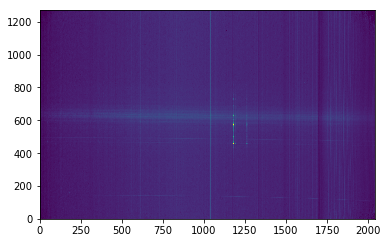

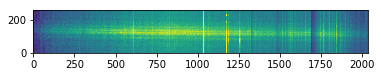

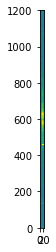

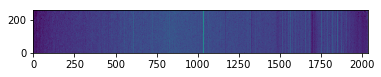

In [4]:
plt.figure()
scidata = hdus[0].data
scidata_spectral = hdus[0].data[500:760,0:2100] #slice spectral direction
scidata_spacial = hdus[0].data[0:1200,1245:1270] #slice spacial direction
sky = hdus[0].data[900:1160,0:2100] #slice spectral direction for sky
#scidata = hdus[0].data[0:10,10:1000] #slice
plt.imshow(scidata, origin = 'lower', vmin = 0, vmax = 2000)
plt.show()

plt.figure()
plt.imshow(scidata_spectral, origin = 'lower', vmin = 0, vmax = 500)
plt.show()


plt.figure()
plt.imshow(scidata_spacial, origin = 'lower', vmin = 0, vmax = 500)
plt.show()

plt.figure()
plt.imshow(sky, origin = 'lower', vmin = 0, vmax = 1000)
plt.show()

## Obtain spectrum

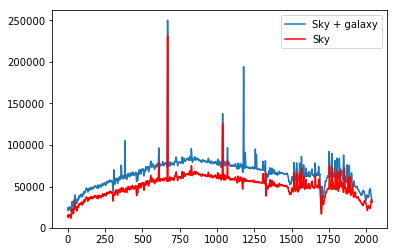

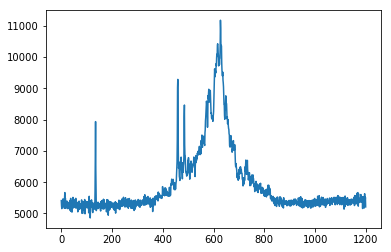

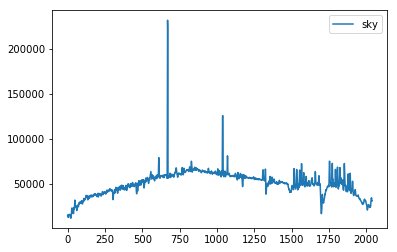

In [11]:
plt.figure()
profile_spectral = scidata_spectral.sum(axis=0)
profile_spacial = scidata_spacial.sum(axis=1)
profile_sky = sky.sum(axis=0)
plt.plot(profile_spectral,label='Sky + galaxy')
plt.plot(profile_sky,'r',label='Sky')
plt.legend()
plt.show()

# Intensity of emission along a given spectral line
plt.figure()
plt.plot(profile_spacial)
plt.show()

x=np.linspace(1,len(profile_sky),len(profile_sky))

# Sky spectrum
plt.plot(profile_sky, label='sky')
plt.legend()
plt.show()


# np.savetxt('sky.dat', np.transpose([x,profile_sky]),newline='\n'
#            ,fmt=('%i','%2.8e')
#            ,header=('pixel   counts'))
# np.savetxt('spectrum.dat', np.transpose([x,profile_spectral]),newline='\n'
#            ,fmt=('%i','%2.8e')
#            ,header=('pixel   counts'))

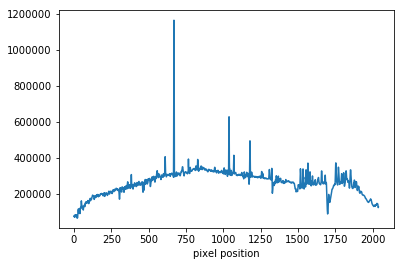

In [13]:
spectrum = scidata.sum(axis=0)
#spect=spectrum[650:720]
plt.figure()
plt.plot(spectrum)
#plt.xlim(600,800)
#plt.ylim(0,50)
plt.xlabel('pixel position')
plt.show()

## Measure of the intensity of the spectrum peaks

A= 934325.506533 +/- 15983.0303266
B= 19.1647991351 +/- 0.0244786439957
C= 1.25099395136 +/- 0.0251794948567
D= 135.10248325 +/- 117.481814192
E= 303298.256216 +/- 4883.0073014


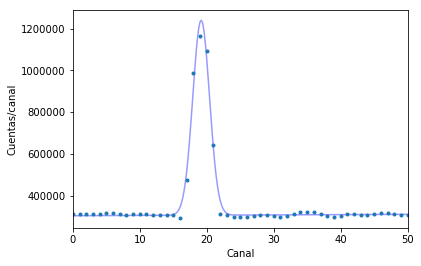

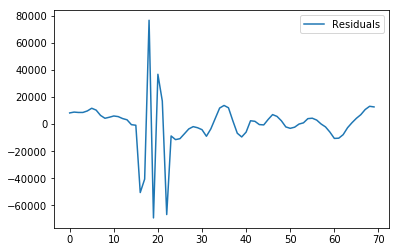

In [21]:
plt.figure()
y = spectrum[650:720]
x= range(len(y))

import scipy.optimize, scipy.stats.stats #Fitting and Statistics

#Plot Data
plt.errorbar(x,y,fmt='.')
plt.xlabel('x (units)')
plt.ylabel('Counts')


#Define a function that we want to fit
def gaussian_with_background(x,A,B,C,D,E):
    return A*np.exp(-(x-B)**2/(2.*C**2)) + D*x + E

#Call the non-linear (Levenburg-Marquardt-based) fitting routine
#scipy.optimize.curve_fit
#http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
#returns answer and covariance


init_vals = [50, 25, 1,0,10]     # for [amp, cen, wid]
#best_vals, covar = curve_fit(gaussian, x, y, p0=init_vals)
ans, cov = scipy.optimize.curve_fit(gaussian_with_background, x, y,p0=init_vals)#,sigma=e)

print("A=", ans[0], "+/-", np.sqrt(cov[0][0]))
print("B=", ans[1], "+/-", np.sqrt(cov[1][1]))
print("C=", ans[2], "+/-", np.sqrt(cov[2][2]))
print("D=", ans[3], "+/-", np.sqrt(cov[3][3]))
print("E=", ans[4], "+/-", np.sqrt(cov[4][4]))


xseq,dx=np.linspace(0,1000,5000,retstep=True)

model=gaussian_with_background(xseq,ans[0],ans[1],ans[2],ans[3],ans[4])

plt.plot(xseq,model,'b-',label='Model',alpha=0.4)


#Plot data, best-fit model, and residual
model = gaussian_with_background(x,ans[0], ans[1], ans[2], ans[3], ans[4])
residual = y - model

# One of the Sky-spectrum's peaks
plt.xlim(0,50)
plt.xlabel('Canal')
plt.ylabel('Cuentas/canal')
plt.show()

plt.plot(residual, label='Residuals')
plt.legend()
plt.show()

# Compute model chi2
#chisq = (residual**2/e**2).sum()
#dof = len(y)-len(ans)
#print('Chi-Sq =', chisq)
#print('dof = ', dof)
#print('PTE = ', scipy.stats.stats.chisqprob(chisq,dof))

## Substraction of sky from obtained spectrum

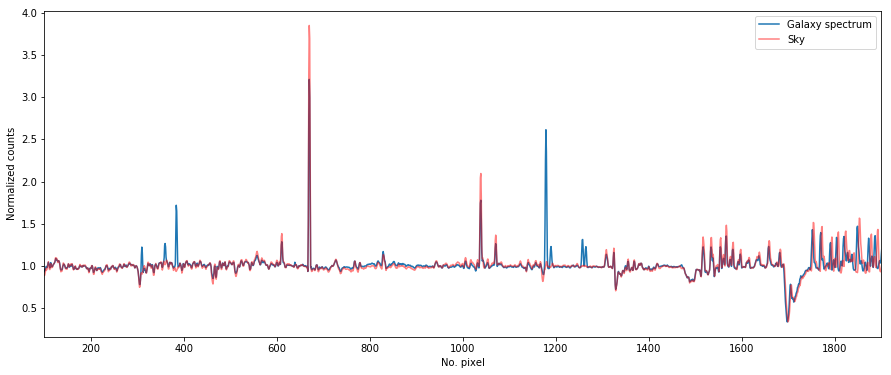

In [20]:
spec=np.loadtxt('spectrum_norm.dat')
sky=np.loadtxt('sky_norm.dat')
x=spec[:,0]
espectro=spec[:,1]
sky_espectro=sky[:,1]

plt.figure(figsize=(15,6))
plt.plot(x,espectro,label='Galaxy spectrum')
plt.plot(x,sky_espectro,'r',alpha=0.5,label='Sky')
plt.xlim(100,1900)
plt.xlabel('No. pixel')
plt.ylabel('Normalized counts')
plt.legend()
plt.show()

# Plot spectrum in the differents region of the galaxy
After manual wavelength calibration, extracting (and stacking several contiguous pixel rows) the spectrum using IRAF. Note that the spectrum has been splitted into two parts because of the lack of flatness in the raw image.

In [22]:
wlen_1a,I1a=np.loadtxt('1a.dat',unpack=True)
I1a=I1a[1001:2039]
wlena=wlen_1a[1001:2039]
wlen_1b,I1b=np.loadtxt('1b.dat',unpack=True)
I1b=I1b[0:1000]
wlenb=wlen_1b[0:1000]
I1=np.append(I1b,I1a)
wlen=np.append(wlenb,wlena)
# 
wlen_2a,I2a=np.loadtxt('2a.dat',unpack=True)
wlen_2b,I2b=np.loadtxt('2b.dat',unpack=True)
I2a=I2a[1001:2039]
I2b=I2b[0:1000]
I2=np.append(I2b,I2a)
# 
wlen_3a,I3a=np.loadtxt('3a.dat',unpack=True)
wlen_3b,I3b=np.loadtxt('3b.dat',unpack=True)
I3a=I3a[1001:2039]
I3b=I3b[0:1000]
I3=np.append(I3b,I3a)
# 
wlen_4a,I4a=np.loadtxt('4a.dat',unpack=True)
wlen_4b,I4b=np.loadtxt('4b.dat',unpack=True)
I4a=I4a[1001:2039]
I4b=I4b[0:1000]
I4=np.append(I4b,I4a)
# 
wlen_5a,I5a=np.loadtxt('5a.dat',unpack=True)
wlen_5b,I5b=np.loadtxt('5b.dat',unpack=True)
I5a=I5a[1001:2039]
I5b=I5b[0:1000]
I5=np.append(I5b,I5a)
# 
wlen_6a,I6a=np.loadtxt('6a.dat',unpack=True)
wlen_6b,I6b=np.loadtxt('6b.dat',unpack=True)
I6a=I6a[1001:2039]
I6b=I6b[0:1000]
I6=np.append(I6b,I6a)
# 
wlen_7a,I7a=np.loadtxt('7a.dat',unpack=True)
wlen_7b,I7b=np.loadtxt('7b.dat',unpack=True)
I7a=I7a[1001:2039]
I7b=I7b[0:1000]
I7=np.append(I7b,I7a)
# 
wlen_8a,I8a=np.loadtxt('8a.dat',unpack=True)
wlen_8b,I8b=np.loadtxt('8b.dat',unpack=True)
I8a=I8a[1001:2039]
I8b=I8b[0:1000]
I8=np.append(I8b,I8a)
# 

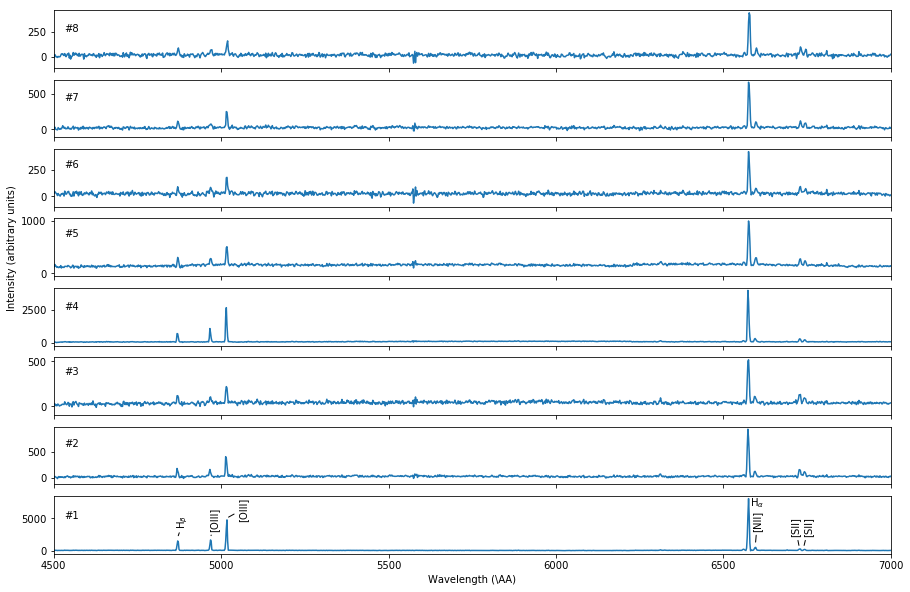

In [27]:
tPlot, axes = plt.subplots(nrows=8, ncols=1, sharex=True, sharey=False,
                           gridspec_kw={'height_ratios':[2,2,2,2,2,2,2,2]},
                           figsize=(15, 10)
                          )

plt.xlim(4500,7000)
axes[7].plot(wlen,I1) 
axes[6].plot(wlen,I2) 
axes[5].plot(wlen,I3) 
axes[4].plot(wlen,I4) 
axes[3].plot(wlen,I5) 
axes[2].plot(wlen,I6) 
axes[1].plot(wlen,I7) 
axes[0].plot(wlen,I8) 

axes[7].text(4530,5000,'#1')
axes[6].text(4530, 600,'#2')
axes[5].text(4530,350,'#3')
axes[4].text(4530, 2500,'#4')
axes[3].text(4530, 700,'#5')
axes[2].text(4530,270,'#6')
axes[1].text(4530, 400,'#7')
axes[0].text(4530,250,'#8')

axes[3].set_ylabel('Intensity (arbitrary units)')
plt.xlabel(r'Wavelength (\AA)')


axes[7].annotate(r'H$_{\alpha}$', xy=(6560, 7000), xytext=(6580, 6900))
axes[7].annotate('[NII]', xy=(6596, 1000), xytext=(6587, 5000),rotation=90, arrowprops=dict(arrowstyle="-"))
axes[7].annotate('[SII]', xy=(6727, 500), xytext=(6700, 4000),rotation=90, arrowprops=dict(arrowstyle="-"))
axes[7].annotate('[SII]', xy=(6740, 500), xytext=(6740, 4000),rotation=90, arrowprops=dict(arrowstyle="-"))
axes[7].annotate(r'H$_{\beta}$', xy=(4870, 2000), xytext=(4865, 4000), rotation=90, arrowprops=dict(arrowstyle="-"))
axes[7].annotate('[OIII]', xy=(4969, 2000), xytext=(4964, 5500),rotation=90, arrowprops=dict(arrowstyle="-"))
axes[7].annotate('[OIII]', xy=(5017, 5000), xytext=(5050, 7000),rotation=90, arrowprops=dict(arrowstyle="-"))

plt.show()